In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.recurrent import LSTM
from keras.backend import squeeze
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
from data_loader import *
import tensorflow as tf
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [2]:
data_file = "/home/mshefa/training_data/training_data_chunk_0.pkl"
data = LoadModRecData(data_file, .9, .1, 0.)

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [3]:
number_of_samples_in_instance = data.instance_shape[1]
data.modTypes

array(['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB',
       'APSK16_c34', 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz',
       'FM_NB', 'FM_WB', 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK', 'NOISE',
       'OQPSK', 'PI4QPSK', 'QAM16', 'QAM32', 'QAM64', 'QPSK'],
      dtype='<U11')

(1, 1024) 498
(1, 1024) 269
(1, 1024) 1504
(1, 1024) 479
(1, 1024) 1058
(1, 1024) 1011
(1, 1024) 1628
(1, 1024) 1900
(1, 1024) 1666
(1, 1024) 1460
(1, 1024) 1330
(1, 1024) 894
(1, 1024) 1623
(1, 1024) 1277
(1, 1024) 1481
(1, 1024) 1095
(1, 1024) 1796
(1, 1024) 1813
(1, 1024) 1718
(1, 1024) 1656
(1, 1024) 1701
(1, 1024) 1211


/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(1, 1024) 270
(1, 1024) 1418


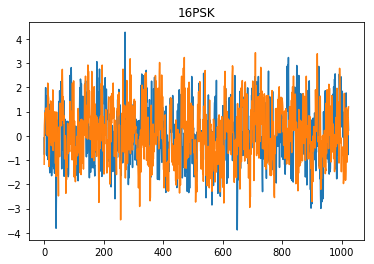

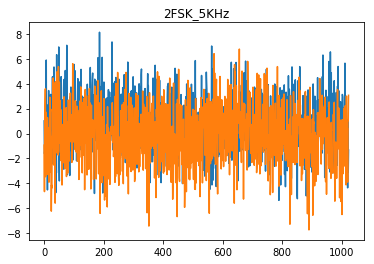

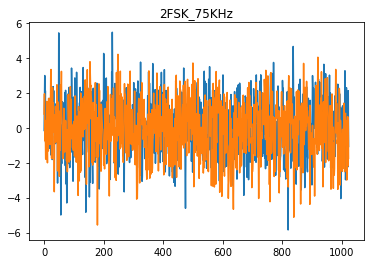

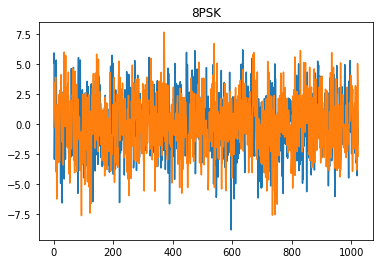

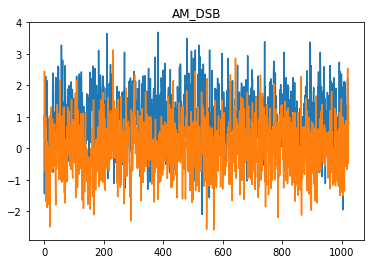

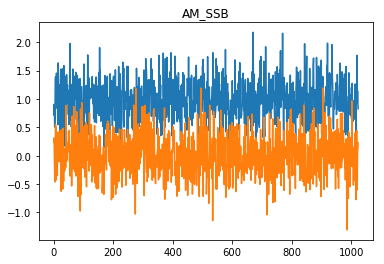

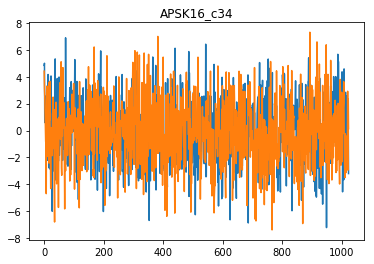

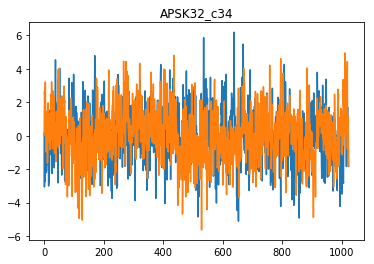

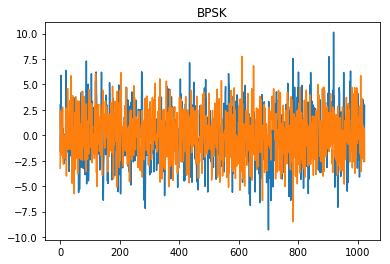

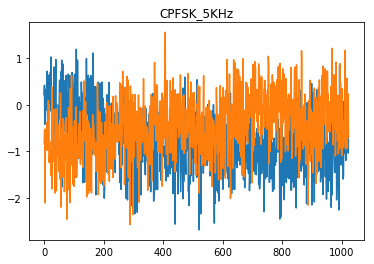

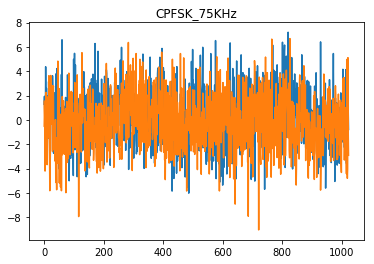

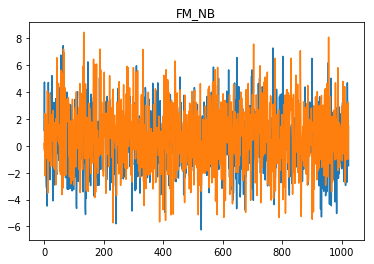

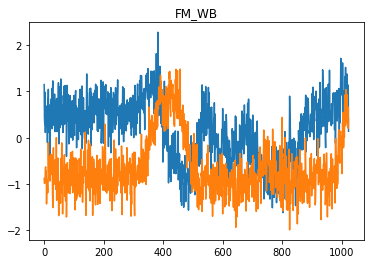

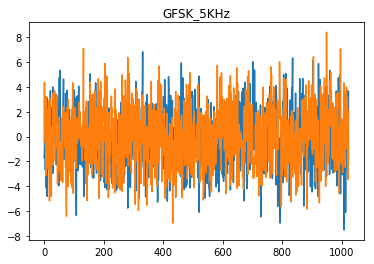

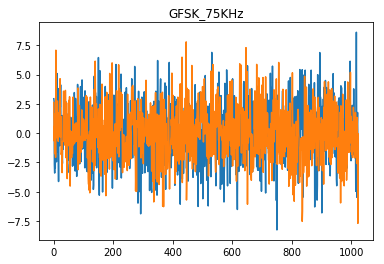

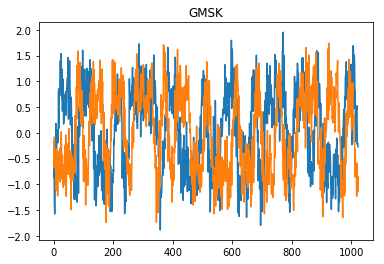

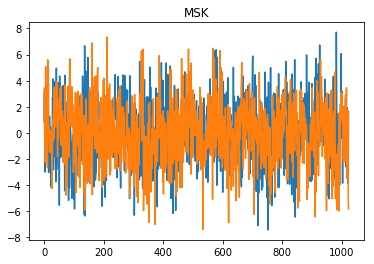

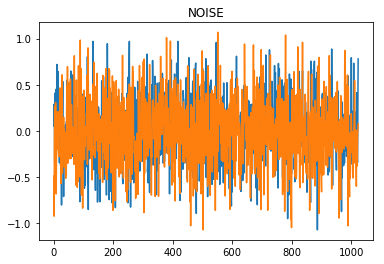

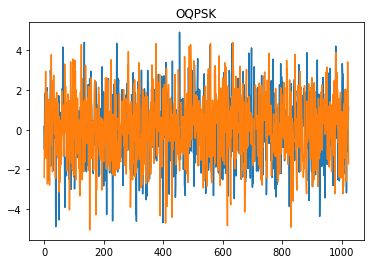

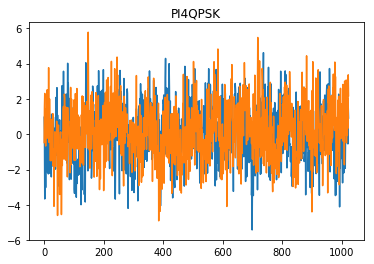

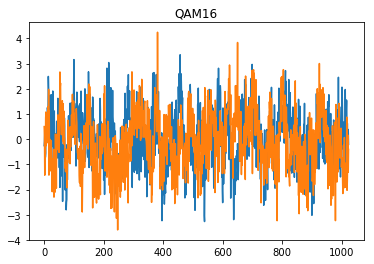

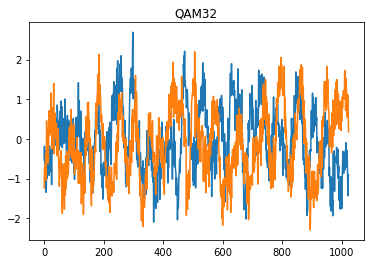

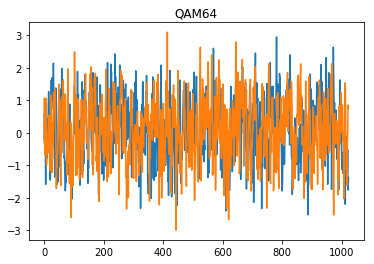

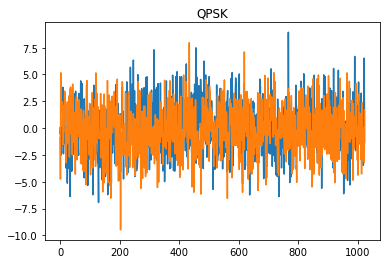

In [4]:
# for each modulation type, inspect some instances of data
for modType in data.modTypes[:]:
    min_SNR = -10
    max_SNR = 10
    snr_step = 4

    # get random snr within valid range
    snrValue = random.randrange(min_SNR, max_SNR, snr_step)

    # get a collection of signals
    collection_of_instances = data.dataCube[modType, snrValue]

    # get the complex samples for a specific instance within the collection
    cdata, index = get_complex_samples_for_instance(collection_of_instances)
    print(cdata.shape,index)

    # setup inspect
    sample_rate = number_of_samples_in_instance
    Ts = 1.0 / sample_rate
    t = np.arange(0, len(cdata[0])) * Ts
    
    plt.figure()
    plt.title(modType)
    plt.plot(cdata.squeeze().real)
    plt.plot(cdata.squeeze().imag)
    # inspect signal
plt.show()
    #data.inspect_signal(index, modType, snrValue, cdata[0], t.tolist(), number_of_samples_in_instance, sample_rate, 0, True)

Using TensorFlow backend.


In [3]:
in_shp = [2,1024]
dr = 0.5 # dropout rate (%)
classes = data.modTypes
with tf.device("/cpu:0"):
    model = models.Sequential()
    model.add(Reshape(in_shp+[1], input_shape=in_shp))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(256, kernel_size=(1, 5), strides=(1,2), border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(80, kernel_size=(2, 3), border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
    rshape = model.output_shape
    print(model.output_shape)
    model.add(Reshape([rshape[2],rshape[3]]))
    model.add(LSTM(64, return_sequences=True, name='lstm1'))
    model.add(LSTM(64, return_sequences=True, name='lstm2'))
    model.add(Dropout(dr))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', init='he_normal', name="dense1"))
    model.add(Dropout(dr))
    model.add(Dense( len(classes), init='he_normal', name="dense2" ))
    model.add(Activation('softmax'))
    model.add(Reshape([len(classes)]))
    model.summary()
model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy', optimizer='adam')

    

/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, kernel_size=(1, 5), strides=(1, 2), activation="relu", name="conv1", padding="valid", kernel_initializer="glorot_uniform")`
  
/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(80, kernel_size=(2, 3), activation="relu", name="conv2", padding="valid", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()


(None, 1, 514, 80)


/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", name="dense1", kernel_initializer="he_normal")`
/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(24, name="dense2", kernel_initializer="he_normal")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 1024, 1)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 2, 1028, 1)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 512, 256)       1536      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 512, 256)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 2, 516, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 514, 80)        122960    
_________________________________________________________________
reshape_2 (Reshape)          (None, 514, 80)           0         
__________

In [4]:
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
train_batch_size, number_of_epochs = 256, 10
tsteps = data.train_idx.size/train_batch_size
vsteps = data.val_idx.size/train_batch_size
train_batches = data.batch_iter(data.train_idx, train_batch_size, number_of_epochs, use_shuffle=True)
val_batches = data.batch_iter(data.val_idx, train_batch_size, number_of_epochs, use_shuffle=False)

history = model.fit_generator(train_batches,
    nb_epoch=number_of_epochs,
    steps_per_epoch=tsteps,
    verbose=2,
    validation_data=val_batches,
    validation_steps=vsteps,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# # we re-load the best weights once training is finished
# model.load_weights(filepath)

/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1012.5, verbose=2, validation_data=<generator..., validation_steps=112.5, callbacks=[<keras.ca..., epochs=10)`
  app.launch_new_instance()


Epoch 1/10


KeyboardInterrupt: 

NameError: name 'history' is not defined

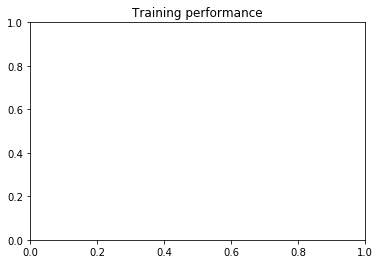

In [13]:
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [25]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
test_file = "/home/mshefa/training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(test_file, 0., 0., 1.)

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [20]:
# Plot confusion matrix# Plot c 
data_file = "/home/mshefa/training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(data_file, .0, .0, 1.)
X_test = testdata.signalData[data.test_idx]
Y_test = testdata.oneHotLabels[data.test_idx]
test_Y_hat = model.predict(X_test, batch_size=train_batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plt.figure(figsize=(14,14))
plot_confusion_matrix(confnorm, labels=classes)

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

ValueError: Error when checking input: expected input_4 to have shape (1024, 2) but got array with shape (2, 1024)

SNR -15 Overall Accuracy:  0.28479166666666667 Out of 48000
SNR -10 Overall Accuracy:  0.3563645833333333 Out of 96000
SNR -5 Overall Accuracy:  0.580125 Out of 48000
SNR 0 Overall Accuracy:  0.6467291666666667 Out of 48000
SNR 5 Overall Accuracy:  0.7140416666666667 Out of 96000
SNR 10 Overall Accuracy:  0.7402291666666667 Out of 48000


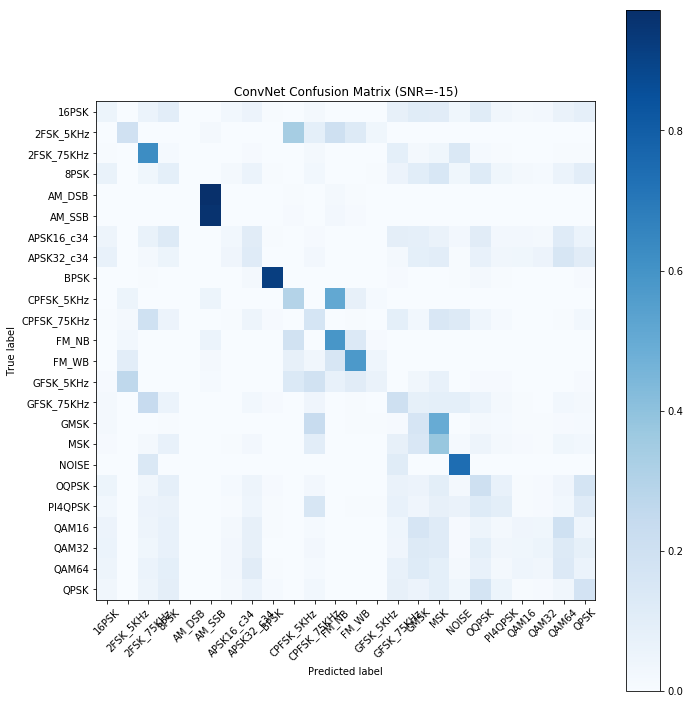

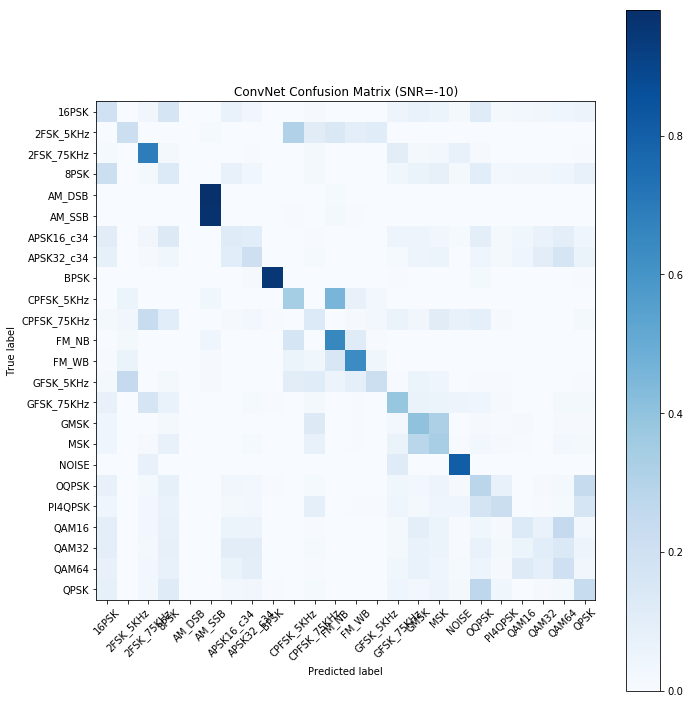

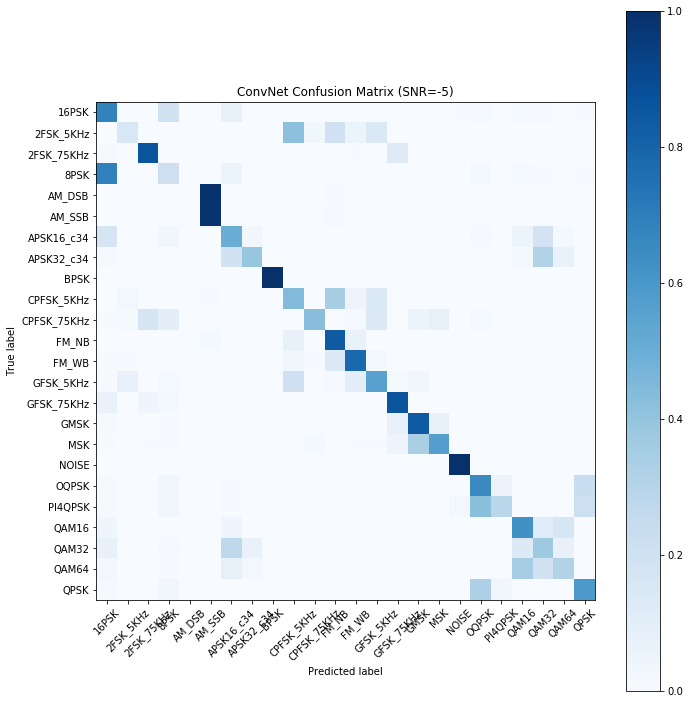

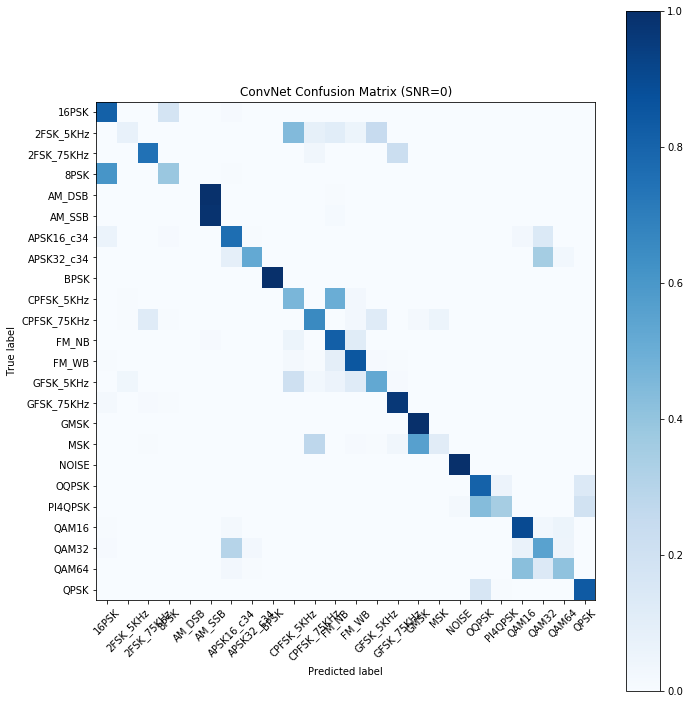

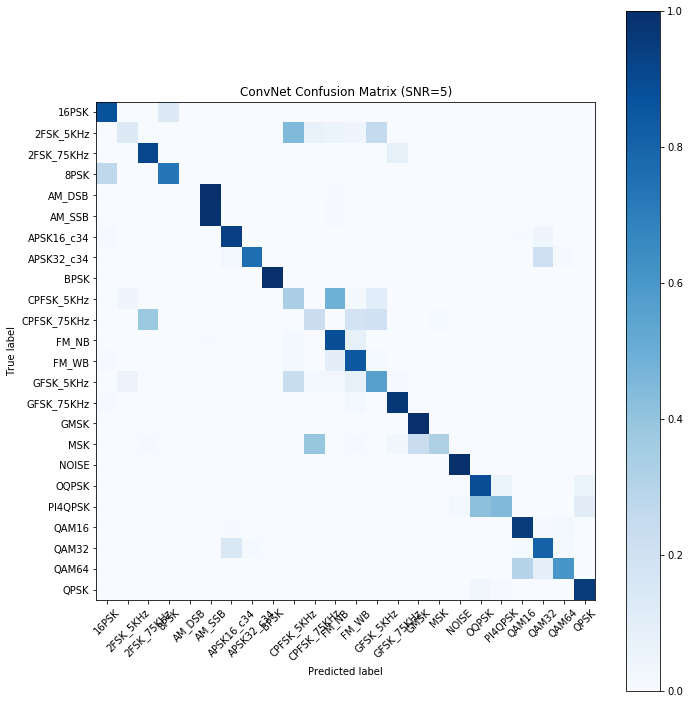

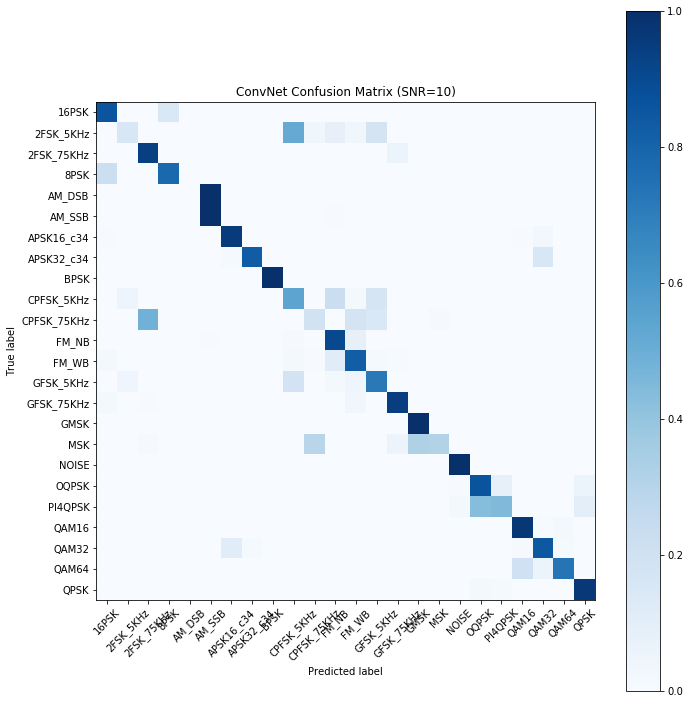

In [26]:

# Plot confusion matrix
acc = {}
snrs = np.arange(-15,15, 5)
classes = testdata.modTypes
for snr in snrs:

    # extract classes @ SNR
    snrThreshold_lower = snr
    snrThreshold_upper = snr+5
    snr_bounded_test_indicies = testdata.get_indicies_withSNRthrehsold(data.test_idx, snrThreshold_lower, snrThreshold_upper)
    
    test_X_i = testdata.signalData[snr_bounded_test_indicies]
    test_X_i = np.transpose(test_X_i, (0,2,1))
    test_Y_i = testdata.oneHotLabels[snr_bounded_test_indicies]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR", snr, "Overall Accuracy: ", cor / (cor+ncor), "Out of", len(snr_bounded_test_indicies))
    acc[snr] = 1.0*cor/(cor+ncor)

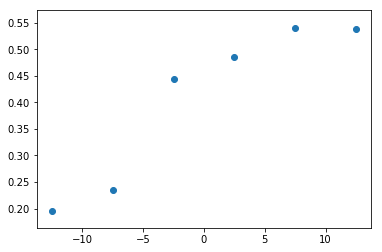

In [38]:
plt.scatter(np.array(list(acc.keys()))+2.5, list(acc.values()))

In [37]:
acc

{-15: 0.19625,
 -10: 0.23449571935685948,
 -5: 0.4435517970401691,
 0: 0.4856909239574816,
 5: 0.540625,
 10: 0.5371308016877637}

In [43]:
from keras.layers.recurrent import 

In [80]:
def get_params(size=10):
    
    f1, f2, f3, stride1, kernel1 = [], [], [], [], []
    for i in range(size):
        f1.append(random.randint(5,10))
        f2.append(random.randint(5, f1[-1]))
        f3.append(random.randint(5, 8))
        if np.random.random() > 0.5:
            s1 = (1,2)
        else:
            s1 = (1,1)
        if np.random.random() > 0.5:
            k1 = (1,5)
        else:
            k1 = (1,3)
        stride1.append(s1)
        kernel1.append(k1)
    f1 = 2**np.asarray(f1)
    f2 = 2**np.asarray(f2)
    f3 = 2**np.asarray(f3)
    return f1, f2, f3, stride1, kernel1
print(get_params(10))

def build_model(f1, f2, f3, kernel1, stride1, dr=0.5, in_shp=[2,1024]):
    model = models.Sequential()
    model.add(Reshape(in_shp+[1], input_shape=in_shp))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(f1, kernel_size=kernel1, strides=stride1, border_mode='valid', activation="relu", name="conv1", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(ZeroPadding2D((0, 2)))
    model.add(Convolution2D(f2, kernel_size=(2,3), border_mode="valid", activation="relu", name="conv2", init='glorot_uniform'))
    model.add(Dropout(dr))
    model.add(Flatten())
    model.add(Dense(f3, activation='relu', init='he_normal', name="dense1"))
    model.add(Dropout(dr))
    model.add(Dense( len(classes), init='he_normal', name="dense2" ))
    model.add(Activation('softmax'))
    model.add(Reshape([len(classes)]))
    model.summary()
    return model

(array([ 128, 1024, 1024, 1024, 1024,  256,   32, 1024,  128,  128]), array([ 64, 512, 256, 128,  32,  32,  32, 512,  32,  32]), array([128, 256,  32,  32, 128,  32, 128, 128, 128,  32]), [(1, 2), (1, 1), (1, 2), (1, 1), (1, 2), (1, 1), (1, 1), (1, 2), (1, 1), (1, 1)], [(1, 3), (1, 3), (1, 5), (1, 3), (1, 5), (1, 3), (1, 5), (1, 3), (1, 3), (1, 3)])


In [13]:
from keras.layers import Layer
from keras import backend as K
from keras.engine.base_layer import InputSpec
class _GlobalPooling1D(Layer):
    """Abstract class for different global pooling 1D layers.
    """

    def __init__(self, **kwargs):
        super(_GlobalPooling1D, self).__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[2])

    def call(self, inputs):
        raise NotImplementedError
class GlobalAveragePooling1D(_GlobalPooling1D):
    """Global average pooling operation for temporal data.
    # Input shape
        3D tensor with shape: `(batch_size, steps, features)`.
    # Output shape
        2D tensor with shape:
        `(batch_size, features)`
    """

    def call(self, inputs, keepdims=True):
        return K.mean(inputs, axis=1, keepdims=keepdims)

## 1D Inception

In [14]:
from keras.layers import Input

from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras import backend as K 

def inception(input_img, fs=[64,64,64,64,64], with_residual=False):
    tower_1 = Conv1D(fs[0], 1, padding='same', activation='relu')(input_img)
    tower_1 = Conv1D(fs[1], 3, padding='same', activation='relu')(tower_1)
    tower_2 = Conv1D(fs[2], 1, padding='same', activation='relu')(input_img)
    tower_2 = Conv1D(fs[3], 5, padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling1D(3, strides=1, padding='same')(input_img)
    tower_3 = Conv1D(fs[4], 1, padding='same', activation='relu')(tower_3)
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 2)
    if with_residual and output.shape==input_img.shape:
        output = output+input_img
    return output
def googleNet(x, data_format='channels_last'):
    x = Conv1D(64, 7, strides=2, data_format=data_format, padding='same', activation='relu')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(2):
        x = Conv1D(192, 3, strides=1, padding='same', activation='relu')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(4):
        x = inception(x, fs=[32,64,32,64,64])
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(10):
        x = inception(x, fs=[48,96,48,96,96], with_residual=True)
    x = MaxPooling1D(3, strides=2, padding='same')(x)
    for dep in range(4):
        x = inception(x, fs=[32,64,32,64,64])
    x = GlobalAveragePooling1D()(x, keepdims=True)
    x = Dropout(0.4)(x)
    output = Flatten()(x)
    out    = Dense(24, activation='softmax')(output)
    return out

input_img = Input(shape=(1024,2))
out = googleNet(input_img,data_format='channels_last')
model = Model(inputs=input_img, outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1024, 2)      0                                            
__________________________________________________________________________________________________
conv1d_280 (Conv1D)             (None, 512, 64)      960         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_67 (MaxPooling1D) (None, 256, 64)      0           conv1d_280[0][0]                 
__________________________________________________________________________________________________
conv1d_281 (Conv1D)             (None, 256, 192)     37056       max_pooling1d_67[0][0]           
__________________________________________________________________________________________________
conv1d_282

In [15]:
def get_data(data_format='channel_last'):
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    BASEDIR = "/home/mshefa/training_data/"
    data_file = BASEDIR+"training_data_chunk_0.pkl"
    data = LoadModRecData(data_file, .9, .1, 0.)
    
    x_train = data.signalData[data.train_idx]
    y_train = data.oneHotLabels[data.train_idx] 
    x_val = data.signalData[data.val_idx]
    y_val = data.oneHotLabels[data.val_idx]
    if data_format == "channel_last":
        x_train = np.transpose(x_train, (0,2,1))
        x_val = np.transpose(x_val, (0,2,1))

    return x_train, y_train, x_val, y_val
x_train, y_train, x_val, y_val =get_data()

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [18]:
filepath = './basemodels/inception.wts.h5'
model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy', optimizer='adam')
train_batch_size, number_of_epochs = 512, 10
history = model.fit(x_train, y_train,
          batch_size=train_batch_size,
          epochs=20,
          verbose=2,
          validation_data=(x_val, y_val),
          callbacks = [
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
          ])
score, acc = model.evaluate(x_val, y_val, verbose=0)
print('Test accuracy:', acc)

Train on 259200 samples, validate on 28800 samples
Epoch 1/20
 - 169s - loss: 2.2988 - val_loss: 1.8220
Epoch 2/20
 - 139s - loss: 1.7432 - val_loss: 1.5956
Epoch 3/20
 - 140s - loss: 1.5103 - val_loss: 1.4232
Epoch 4/20
 - 139s - loss: 1.3528 - val_loss: 1.2565
Epoch 5/20
 - 138s - loss: 1.2514 - val_loss: 1.1709
Epoch 6/20
 - 140s - loss: 1.1933 - val_loss: 1.1315
Epoch 7/20
 - 139s - loss: 1.1452 - val_loss: 1.1222
Epoch 8/20
 - 141s - loss: 1.1102 - val_loss: 1.0770
Epoch 9/20
 - 140s - loss: 1.0796 - val_loss: 1.0471
Epoch 10/20
 - 139s - loss: 1.0506 - val_loss: 1.0549
Epoch 11/20
 - 139s - loss: 1.0350 - val_loss: 1.0301
Epoch 12/20
 - 142s - loss: 1.0121 - val_loss: 1.0604
Epoch 13/20
 - 143s - loss: 0.9870 - val_loss: 0.9845
Epoch 14/20
 - 141s - loss: 0.9684 - val_loss: 0.9593
Epoch 15/20
 - 142s - loss: 0.9582 - val_loss: 0.9673
Epoch 16/20
 - 143s - loss: 0.9385 - val_loss: 1.0027
Epoch 17/20
 - 140s - loss: 0.9264 - val_loss: 1.0692
Epoch 18/20
 - 144s - loss: 0.9132 - val

TypeError: 'numpy.float64' object is not iterable

## 2D resnet

In [2]:
from resnet2D import ResnetBuilder
from custom_layers import get_data
img_train, y_train, img_val, y_val = get_data(mode='fourier')
img_train = img_train[:,:,16:48,:]
img_val = img_val[:,:,16:48,:]

[Data Loader] - Loading Data...
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: FM_NB
[Data Loader] - [Modulation Dataset] Adding Collects for: 

In [3]:
from resnet2D import ResnetBuilder
img_channels, img_rows, img_cols = 2, 16, 32
model = ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), 24)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 32, 2)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 32, 64)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 32, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [ ]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
csv_logger = CSVLogger('resnet18_cifar10.csv')
hist = model.fit(img_train, y_train,
          batch_size=256,
          nb_epoch=20,
          validation_data=(img_val, y_val),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, csv_logger])

/home/yunfanz/miniconda3/envs/seti/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


Train on 259200 samples, validate on 28800 samples
Epoch 1/20
259200/259200 [==============================] - 138s 531us/step - loss: 3.4134 - acc: 0.0414 - val_loss: 3.2158 - val_acc: 0.0399
Epoch 2/20
 79104/259200 [========>.....................] - ETA: 1:27 - loss: 3.2076 - acc: 0.0429

In [5]:
img_val.shape

(28800, 16, 64, 2)

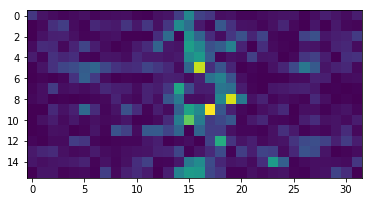

In [16]:
a = img_val[6]
a = a[...,0]**2+a[...,1]**2
a = a[:,16:48]
plt.imshow(a)